In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!rm -rf 

In [0]:
!git clone https://github.com/invite-you/simplified_rbox_cnn.git

Cloning into 'simplified_rbox_cnn'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 465 (delta 26), reused 0 (delta 0), pack-reused 423
Receiving objects: 100% (465/465), 4.45 MiB | 10.15 MiB/s, done.
Resolving deltas: 100% (156/156), done.


In [0]:
!git pull origin master 

remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.
From https://github.com/invite-you/simplified_rbox_cnn
 * branch            master     -> FETCH_HEAD
   0602970..76de80a  master     -> origin/master
Updating 0602970..76de80a
Fast-forward
 create_dataset.py | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)


In [0]:
cd simplified_rbox_cnn

/content/simplified_rbox_cnn


In [0]:
ls -alt /content/gdrive/'My Drive'/findShip/models

In [0]:
!python create_dataset.py


N of TFRecords: 5422
N of TFRecords: 5564


In [2]:
!pip install git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-1exrzbnr
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-1exrzbnr
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=275363 sha256=206444715ef160f8fa87aa72c4d24a58ab6e0adf5e6377d176ca41e6d9536205
  Stored in directory: /tmp/pip-ephem-wheel-cache-8xkoc5ee/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools


In [0]:
import os
import json
import argparse
import math
from collections import namedtuple

import numpy as np
import cv2
from tqdm import tqdm
from skimage.io import imread
import shapely
from shapely.geometry import Polygon
import tensorflow as tf

from functools import reduce
import operator

# Object Class
Object = namedtuple('Object', 'coord poly cls_idx cls_text')

# Pacth Class
Patch = namedtuple('Patch', 'image_id image row col objects')


In [0]:
def get_patch_image(image, row, col, patch_size):
    patch_image_height = patch_size if image.shape[0] - row > patch_size else image.shape[0] - row
    patch_image_width = patch_size if image.shape[1] - col > patch_size else image.shape[1] - col

    patch_image = image[row: row + patch_image_height, col: col + patch_image_width]

    if patch_image_height < patch_size or patch_image_width < patch_size:
        pad_height = patch_size - patch_image_height
        pad_width = patch_size - patch_image_width
        patch_image = np.pad(patch_image, ((0, pad_height), (0, pad_width), (0, 0)), 'constant')

    return patch_image

def load_geojson(filename):
    """ Gets label data from a geojson label file
    :param (str) filename: file path to a geojson label file
    :return: (numpy.ndarray, numpy.ndarray ,numpy.ndarray) coords, chips, and classes corresponding to
            the coordinates, image names, and class codes for each ground truth.
    """

    with open(filename) as f:
        data = json.load(f)

    obj_coords = np.zeros((len(data['features']), 8))
    image_ids = np.zeros((len(data['features'])), dtype='object')
    class_indices = np.zeros((len(data['features'])), dtype=int)
    class_names = np.zeros((len(data['features'])), dtype='object')

    for idx in range(len(data['features'])):
        properties = data['features'][idx]['properties']
        image_ids[idx] = properties['image_id']
        obj_coords[idx] = np.array([float(num) for num in properties['bounds_imcoords'].split(",")])
        class_indices[idx] = properties['type_id']
        class_names[idx] = properties['type_name']

    return image_ids, obj_coords, class_indices, class_names

def cvt_coords_to_rboxes(coords):
    """ Processes a coordinate array from a geojson into (cy, cx, height, width, theta) format
    :param (numpy.ndarray) coords: an array of shape (N, 8) with 4 corner points of boxes
    :return: (numpy.ndarray) an array of shape (N, 5) with coordinates in proper format
    """

    rboxes = []
    for coord in coords:
        pts = np.reshape(coord, (-1, 2)).astype(dtype=np.float32)
        (cx, cy), (width, height), theta = cv2.minAreaRect(pts)

        if width < height:
            width, height = height, width
            theta += 90.0
        rboxes.append([cy, cx, height, width, math.radians(theta)])

    return np.array(rboxes)


def cvt_coords_to_polys(coords):
    """ Convert a coordinate array from a geojson into Polygons
    :param (numpy.ndarray) coords: an array of shape (N, 8) with 4 corner points of boxes
    :return: (numpy.ndarray) polygons: an array of shapely.geometry.Polygon corresponding to coords
    """

    polygons = []
    for coord in coords:
        polygons.append(Polygon([coord[0:2], coord[2:4], coord[4:6], coord[6:8]]))
    return np.array(polygons)


def IoA(poly1, poly2):
    """ Intersection-over-area (ioa) between two boxes poly1 and poly2 is defined as their intersection area over
    box2's area. Note that ioa is not symmetric, that is, IOA(poly1, poly2) != IOA(poly1, poly2).
    :param (shapely.geometry.Polygon) poly1: Polygon1
    :param (shapely.geometry.Polygon) poly2: Polygon2
    :return: (float) IoA between poly1 and poly2
    """
    return poly1.intersection(poly2).area / poly1.area

def rotate_box(bb, cx, cy, theta):
    new_bb = list(bb)
    for i, coord in enumerate(bb):
        # opencv calculates standard transformation matrix
        M = cv2.getRotationMatrix2D((cx, cy), theta, 1.0)
        # Prepare the vector to be transformed
        v = [coord[0], coord[1], 1]
        # Perform the actual rotation and return the image
        calculated = np.dot(M, v)
        new_bb[i] = (calculated[0], calculated[1])
    return new_bb


def convert_bbox_to_rbox(cx, cy, h, w, theta):
    x1, y1, x3, y3 = cx-(w/2), cy-(h/2), cx+(w/2), cy+(h/2)
    x4, y4, x2, y2 = cx-(w/2), cy+(h/2), cx+(w/2), cy-(h/2)
    bbox = [(x1, y1), (x2, y2), (x3, y3), (x4, y4)]

    rbox = rotate_box(bbox, cx, cy, -theta)
    
    rbox = [xx for x in rbox for xx in x]
    rbox = sort_clockwise(rbox)
    rbox = [(x, y) for x, y in zip(rbox[0::2], rbox[1::2])]

    return rbox

def sort_clockwise(points):
    r = list(map(float, points))
    coords = [r[0:2], r[2:4], r[4:6], r[6:8]]
    center = tuple(map(operator.truediv, reduce(
        lambda x, y: map(operator.add, x, y), coords), [len(coords)] * 2))
    sorted_coords = sorted(coords, key=lambda coord: (-135 - math.degrees(
        math.atan2(*tuple(map(operator.sub, coord, center))[::-1]))) % 360)
    return [coord for coords in sorted_coords for coord in coords]

In [0]:

def write_data(dst_path, patches):
    """ Write patch information into writer
       :param (str) dst_tfr_path: path to save tfrecords
       :param (list) patches: a list of Patch to save tfrecords
       :param (str) obj_type: object type which is one of {'rbox', 'bbox'}
    """
    images, annotations = [], []
    annts_index = 0
    map_labels = {'aircraft carrier': 1, 'container': 2,
              'oil tanker': 3, 'maritime vessels': 4}

    for image_index, patch in enumerate(patches):
        image_format = b'png'
        image = cv2.cvtColor(patch.image, cv2.COLOR_RGB2BGR)
        image_as_bytes = cv2.imencode('.png', image)[1].tostring()

        encoded_image = image_as_bytes
        patch_height = patch.image.shape[0]
        patch_width = patch.image.shape[1]
        image_filename = patch.image_id.encode()

        image_id = patch.image_id.split(".")[0]
        images.append({
            "license": 1,
            "file_name": F"{image_id}_{patch.row}_{patch.col}.png",
            "coco_url": "",
            "height": patch_height,
            "width": patch_width,
            "date_captured": "2013-11-14 17:02:52",
            "flickr_url": "",
            "id": image_index,
            "image": image
        })

        center_ys, center_xs, heights, widths, thetas, class_indices, class_texts = [], [], [], [], [], [], []
        for coord, polys, cls_idx, cls_text in patch.objects:
            """
            center_ys.append(coord[0])
            center_xs.append(coord[1])
            heights.append(coord[2])
            widths.append(coord[3])
            thetas.append(coord[4])
            class_texts.append(cls_text.encode())
            class_indices.append(cls_idx)
            """

            
            rbox = convert_bbox_to_rbox(
                coord[1], coord[0], coord[2], coord[3], coord[4])
            
            xs = np.array(rbox)[:, 0]
            ys = np.array(rbox)[:, 1]
            xyMin = [min(xs), min(ys)]
            xyMax = [max(xs), max(ys)]
            xyMin.extend(xyMax)

            seg = [xx for x in rbox for xx in x]
            seg = sort_clockwise(seg)
            seg.extend([seg[0], seg[1]])

            annotations.append({
                    "segmentation": seg,
                    "area": Polygon(rbox).area,
                    "iscrowd": 0,
                    "image_id": image_index,
                    "bbox": xyMin,  # (minx, miny, maxx, maxy)
                    "category_id": map_labels[cls_text],
                    "id": annts_index,
                    "image_file": patch.image_id
            })
            annts_index+=1
            """
            for poly in polys:
                seg = list(poly.exterior.coords)                
                annotations.append({
                    "segmentation": [xx for x in seg for xx in x],
                    "area": poly.area,
                    "iscrowd": 0,
                    "image_id": image_index,
                    "bbox": poly.bounds,  # (minx, miny, maxx, maxy)
                    "category_id": map_labels[cls_text],
                    "id": annts_index
                })
                annts_index+=1
            """
    return images, annotations    

In [0]:
annotations[0]

In [0]:
list(shift.exterior.coords)

In [0]:
dir(objects_in_patch[0].poly)

In [224]:
obj_coords_in_image

array([[3.08905029e+02, 2.15871313e+03, 7.60160904e+01, 3.76261292e+02,
        1.00004555e+00]])

In [238]:
geojson_path = os.path.join(src_dir, 'labels.json')
image_ids, obj_coords, class_indices, class_names = load_geojson(geojson_path)

obj_polys = cvt_coords_to_polys(obj_coords)
obj_coords = cvt_coords_to_rboxes(obj_coords)


image_id = "3.png"
obj_coords_in_image = obj_coords[image_ids == image_id]
obj_polys_in_image = obj_polys[image_ids == image_id]
obj_coords_in_image, obj_polys_in_image

(array([[180.27137756, 567.96600342,  50.59592819, 131.01126099,
           1.36135672],
        [171.35150146, 520.88250732,  43.08073044, 104.08580017,
           1.39626314]]),
 array([<shapely.geometry.polygon.Polygon object at 0x7fc441caa9b0>,
       dtype=object))

In [239]:
list(map(int, obj_coords_in_image[0])), obj_polys_in_image[0].bounds

([180, 567, 50, 131, 1],
 (529.6014884520317,
  110.93746488013034,
  606.3305545704899,
  249.60528675031043))

In [264]:
patch_poly.bounds

(2560.0, 0.0, 3072.0, 512.0)

In [265]:
obj_poly.bounds

(546.6821435437615, 478.6108088201476, 1505.5381418532816, 795.4661928451637)

In [313]:
src_dir="/content/gdrive/My Drive/findShip/"
dst_path="/content/gdrive/My Drive/findShip/custom_coco"
patch_size=512#1024
patch_overlay=256#384
object_fraction_thresh=0.5
is_include_only_pos=True

images, annotations = [], []

n_tfrecord = 0

# Load objects from geojson
geojson_path = os.path.join(src_dir, 'labels.json')
image_ids, obj_coords, class_indices, class_names = load_geojson(geojson_path)

obj_polys = cvt_coords_to_polys(obj_coords)
obj_coords = cvt_coords_to_rboxes(obj_coords)

# Load image files as TIF
for image_id in tqdm(sorted(set(image_ids))):

    image = imread(os.path.join(src_dir, 'images/', image_id))

    # Get data in the current image
    obj_coords_in_image = obj_coords[image_ids == image_id]
    obj_polys_in_image = obj_polys[image_ids == image_id]
    class_indices_in_image = class_indices[image_ids == image_id]
    class_texts_in_image = class_names[image_ids == image_id]

    # Create patches including objects
    patches = []
    step = patch_size - patch_overlay
    for row in range(0, image.shape[0] - patch_overlay, step):
        for col in range(0, image.shape[1] - patch_overlay, step):
            patch_poly = Polygon([(col, row), (col + patch_size, row),
                                    (col + patch_size, row + patch_size), (col, row + patch_size)])

            # Check if a patch contains objects and append objects
            objects_in_patch = []
            for idx, obj_poly in enumerate(obj_polys_in_image):
                if IoA(obj_poly, patch_poly) > object_fraction_thresh:
                    objects_in_patch.append(Object(obj_coords_in_image[idx], obj_poly, class_indices_in_image[idx],
                                                    class_texts_in_image[idx]))
            
            # if a patch contains objects, append the patch to save tfrecords
            if not is_include_only_pos or objects_in_patch:
                objects_in_patch = [
                    Object(coord=[obj.coord[0] - row, obj.coord[1] - col, obj.coord[2], obj.coord[3], obj.coord[4]],
                            poly=[shapely.affinity.translate(obj.poly, xoff=-col, yoff=-row)], cls_idx=obj.cls_idx, cls_text=obj.cls_text) for obj in objects_in_patch]
                patch_image = get_patch_image(image, row, col, patch_size)
                patches.append(
                    Patch(image_id=image_id, image=patch_image, row=row, col=col, objects=objects_in_patch))
        break
    imgs, anns = write_data(dst_path, patches)
    images.extend(imgs)
    annotations.extend(anns)
    n_tfrecord += len(patches)
    if len(annotations) >= 3:  break
print('N of TFRecords:', n_tfrecord)

































  0%|          | 0/1593 [00:00<?, ?it/s]































  0%|          | 1/1593 [00:00<08:33,  3.10it/s]































  0%|          | 2/1593 [00:00<08:28,  3.13it/s]































  0%|          | 3/1593 [00:00<08:25,  3.14it/s]































  0%|          | 4/1593 [00:01<08:22,  3.17it/s]































  0%|          | 5/1593 [00:01<08:20,  3.17it/s]































  0%|          | 6/1593 [00:01<07:42,  3.43it/s]































  0%|          | 7/1593 [00:02<06:59,  3.78it/s]































  1%|          | 8/1593 [00:02<07:18,  3.61it/s]































  1%|          | 9/1593 [00:02<07:39,  3.44it/s]































  1%|          | 10/1593 [00:02<07:54,  3.34it/s]































  1%|          | 11/1593 [00:03<07:23,  3.56it/s]































  1%|         

a
a


































  1%|          | 15/1593 [00:04<07:20,  3.59it/s]































  1%|          | 16/1593 [00:04<07:23,  3.55it/s]































  1%|          | 17/1593 [00:04<06:53,  3.81it/s]































  1%|          | 18/1593 [00:05<07:12,  3.64it/s]































  1%|          | 19/1593 [00:05<06:28,  4.05it/s]































  1%|▏         | 20/1593 [00:05<06:52,  3.82it/s]































  1%|▏         | 21/1593 [00:05<07:15,  3.61it/s]

a
a
a
N of TFRecords: 5


In [306]:
annotations[0]

{'area': 28601.912346372847,
 'bbox': [177.9477827671507,
  267.6192913978496,
  555.4784867640992,
  350.1907671959004],
 'category_id': 4,
 'id': 0,
 'image_file': '101.png',
 'image_id': 0,
 'iscrowd': 0,
 'segmentation': [179.27450689815055,
  267.6192913978496,
  177.9477827671507,
  343.62380311739867,
  554.1517626330993,
  350.1907671959004,
  555.4784867640992,
  274.18625547635133,
  179.27450689815055,
  267.6192913978496]}

In [296]:
images[2]

{'coco_url': '',
 'date_captured': '2013-11-14 17:02:52',
 'file_name': '0_0_1792.png',
 'flickr_url': '',
 'height': 512,
 'id': 0,
 'image': array([[[ 22,   3,   3],
         [ 19,   2,   3],
         [ 19,   1,   2],
         ...,
         [ 17,   1,   2],
         [ 14,   1,   1],
         [ 14,   2,   1]],
 
        [[ 24,   4,   5],
         [ 22,   2,   3],
         [ 24,   3,   3],
         ...,
         [ 14,   0,   1],
         [ 17,   2,   2],
         [ 17,   3,   3]],
 
        [[ 24,   4,   5],
         [ 24,   4,   5],
         [ 27,   4,   6],
         ...,
         [ 14,   1,   1],
         [ 14,   2,   2],
         [ 14,   2,   2]],
 
        ...,
 
        [[109,  89, 140],
         [103,  86, 131],
         [ 94,  79, 118],
         ...,
         [ 93, 106, 139],
         [ 56,  64,  92],
         [ 34,  34,  57]],
 
        [[ 94,  71, 118],
         [ 90,  70, 110],
         [ 88,  69, 103],
         ...,
         [111, 127, 161],
         [ 72,  82, 112],
       

[[154 311]
 [154 383]
 [486 382]
 [485 310]
 [154 311]]
[154 310 486 383]


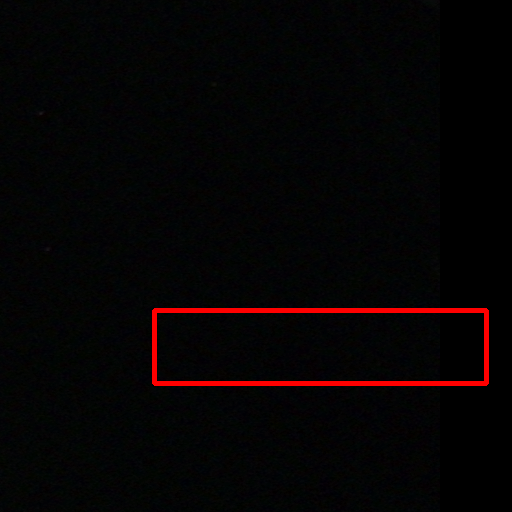

In [312]:
index =4
ann = annotations[index]

image = images[ann['image_id']]['image']

bbox = np.array(ann['bbox'], np.int32)

polygon = ann['segmentation']
polygon = [(x, y) for x, y in zip(polygon[0::2], polygon[1::2])]
polygon = np.array(polygon, np.int32 )
print(polygon)
print(bbox)
image = image.copy()
img = cv2.polylines(image, [polygon], True, (0, 255, 0), 2)  
img = cv2.rectangle(img, (bbox[0], bbox[1]),  (bbox[2], bbox[3]), (0, 0, 255), 3)


cv2_imshow(img)

In [13]:
coco.loadCats(coco.getCatIds())

[{'id': 1, 'name': 'aircraft carrier', 'supercategory': 'ship'},
 {'id': 2, 'name': 'container', 'supercategory': 'ship'},
 {'id': 3, 'name': 'oil tanker', 'supercategory': 'ship'},
 {'id': 4, 'name': 'maritime vessels', 'supercategory': 'ship'}]

In [0]:
coco.loadImgs(1)

[{'coco_url': '',
  'date_captured': '2013-11-14 17:02:52',
  'file_name': '1048_768_0.png',
  'flickr_url': '',
  'height': 1024,
  'id': 1,
  'license': 1,
  'width': 1024}]

In [35]:
import os
from pycocotools.coco import COCO
coco = COCO(os.path.join("/content/gdrive/My Drive/findShip/custom_coco_1024", 'annotations', 'instances_train2017.json'))

loading annotations into memory...
Done (t=1.43s)
creating index...
index created!


[[ 86 668]
 [ 88 731]
 [391 724]
 [390 662]]


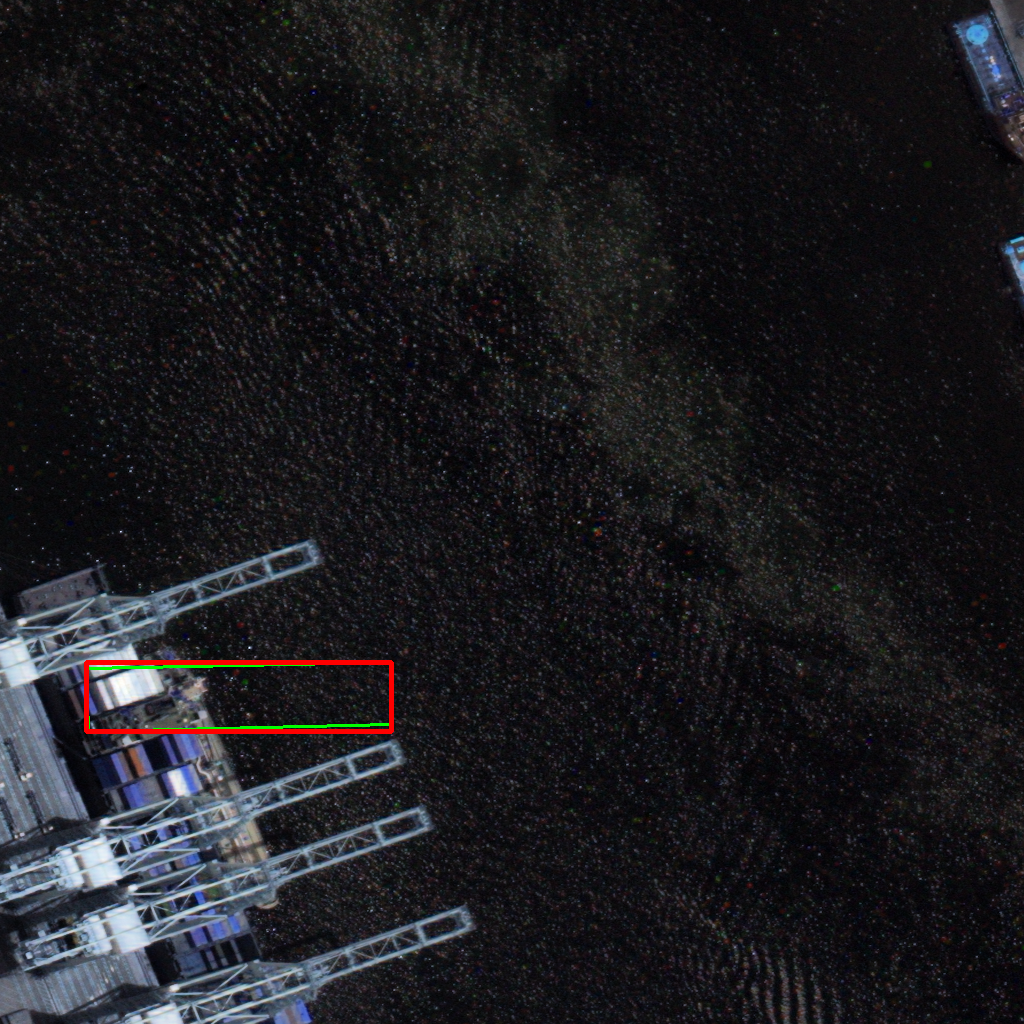

In [38]:
import os 
import os
import pickle
import numpy as np
from skimage.io import imread

import io
import numpy as np
import cv2
from PIL import Image
from google.colab.patches import cv2_imshow
import math
import pandas as pd

import json

base_path = "/content/gdrive/My Drive/findShip/custom_coco_1024"

index = 60

ann = coco.loadAnns([index])[0]
img_info = coco.loadImgs([ ann['image_id'] ])[0]

bbox = list(map(int, ann['bbox']))
seg = ann['segmentation'][0]
polygon = np.array([[x, y] for x, y in zip(seg[0::2], seg[1::2])], np.int32 )
image = imread(os.path.join(base_path, 'train2017', img_info['file_name']))


print(polygon)
img = cv2.polylines(image, [polygon], True, (0, 255, 0), 2)  
img = cv2.rectangle(img, (bbox[0], bbox[1]),  (bbox[2], bbox[3]), (0, 0, 255), 3)


cv2_imshow(img)

In [22]:
[[x, y] for x, y in zip(seg[0::2], seg[1::2])]

[[41.44397904515793,
  21.018288818059276,
  40.16531724623227,
  82.92235516298729,
  200.32262251734204,
  86.23049047881574,
  201.6012843162677,
  24.32642413388772]]